<img src="../../img/backdrop-wh.png" alt="Drawing" style="width: 300px;"/>  

# Gemini API

* * * 

<div class="alert alert-success">  
    
### Learning Objectives 
    
* Setting up Gemini API  
* Making requests to the Gemini API about r/aita posts
* Create embeddings models from r/aita posts
* Explore Gemini's safety settings

</div>

### Icons Used in This Notebook
🔔 **Question**: A quick question to help you understand what's going on.<br>
⚠️ **Warning:** Heads-up about tricky stuff or common mistakes.<br>
💭 **Reflection**: Reflecting on ethical implications, biases, and social impact in data science.<br>


### Sections
1. [What is the Gemini API?](#what)
3. [Gemini and r/AITA](#aita)
4. [Controlling Output](#control)
5. [Visualizing Output as Embeddings](#vis)
6. [Understanding Gemini's Safety Settings](#safe)

<a id='what'></a>

# What is the Gemini API?

The Gemini API offers a way to interact with one of Google’s advanced language models—systems trained to generate, summarize, or reinterpret text and images. Rather than merely a technical tool, we can think of this API as a hermeneutic interface: a structured channel through which human queries are filtered, transformed, and responded to by an algorithmic agent.

In this notebook, we’ll explore how to make API calls to Gemini. We do so to critically reflect on what it means for a machine to respond, and what kinds of interpretations these responses make possible or foreclose.

## Overview of Gemini Models

Google offers different Gemini models, each with its own strengths:

* **Gemini Flash:** This model is super fast and efficient. It's great for tasks where you need quick responses or are handling many requests, like summarizing text on the fly or powering a chatbot that needs to reply instantly. It can understand text, images, audio, and video!
* **Gemini Pro:** This is a more powerful model, excellent for complex tasks that require deeper understanding and reasoning. For example, if you need a detailed analysis or very creative content, Pro is a great choice. It's also multimodal, meaning it can handle different types of input (text, images, etc.).
* **Gemini Ultra:** This is the most capable model, designed for highly complex tasks. (Access to Ultra might be different or more limited, so we'll focus on Flash and Pro for this course as they have generous free tiers to get started).

**Key Capabilities:**
* **Multimodality:** This fancy word means Gemini can understand and process information from different formats, not just text. You can give it an image and ask questions about it, or provide audio and get a transcript. We'll explore this more in Module 2!
* **Long Context:** Some Gemini models can remember and process a very large amount of information at once (like an entire book!). This is called having a "long context window." The `gemini-1.5-flash` and `gemini-1.5-pro` models we'll be looking at can handle up to 1 million *tokens* (we'll explain tokens later), which is a lot of text!

## Setting up Your Environment

To start using the Gemini API, we need a few things.

### Getting API Keys

An API key is like a secret password that tells Google it's really you making the request. For this course, we'll use API keys from **Google AI Studio**.

⚠️ **Warning:** You currently cannot use Google Gemini with your Berkeley account, so you will have to use your personal account.

1.  Go to [Google AI Studio](https://aistudio.google.com/).
2.  You might need to sign in with your Google account.
3.  Look for a button or link like "Get API Key" or "Create API Key".
4.  You may need to create a Project on the [Google Cloud Console](https://console.cloud.google.com/).
5.  Follow the instructions to create a new API key.
6.  **Important:** Copy this key and save it somewhere safe. Don't share it publicly!

For this notebook, we'll ask you to paste your API key in a secure way.

### Billing & Free Quotas
The Gemini API offers a **free tier** of usage for certain models (like gemini-1.5-flash and even gemini-1.5-pro to some extent). This typically includes a certain number of requests per minute (RPM) and potentially per day. For example, gemini-1.5-flash usually has a more generous free RPM than gemini-1.5-pro.

If you are using an API key from Google AI Studio and your usage stays within the free tier limits, you won't be charged. If you exceed the free tier limits, your API calls will typically start failing with a quota error, rather than automatically billing you, *unless* a billing account has been explicitly linked to the underlying Google Cloud project and the project is configured to upgrade to paid usage.

**I strongly advise not to add a billing account to the Google Cloud project associated with your Google AI Studio API key** if your purpose is free-tier exploration for this course.


### Note on package installation

- If you are running this notebook on **DataHub**, you may need to **uncomment and run** the `%pip install ...` line below if you get an error about a missing package. Restart your kernel after running this cell!
- If you are working **locally** (on your own computer), you should already have all required packages installed via your Conda environment (see the ***"Local Python and Jupyter Setup"*** page on bCourses). Only use the `pip install` line if you see an ImportError and know what you’re doing.

In [1]:
#!pip install -U -q google-generativeai
#!pip install umap-learn

In [15]:
import gdown

gdown.download("https://drive.google.com/uc?id=1Glac4spXraWRcC_loxu1Cu4Bw-szS2ou", "../../data/aita_pp.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Glac4spXraWRcC_loxu1Cu4Bw-szS2ou
To: /Users/tomvannuenen/Library/CloudStorage/Dropbox/GitHub/DEV/DIGHUM160/data/aita_pp.csv
100%|██████████████████████████████████████| 56.6M/56.6M [00:00<00:00, 77.8MB/s]


'../../data/aita_pp.csv'

In [16]:
import os
import pandas as pd

In [17]:
df = pd.read_csv('../../data/aita_pp.csv')

### Authentication and Basic API Request Structure

**Authentication** is how the API verifies your identity (using your API key).

Once the SDK is installed, we need to configure it with our API key. Then, a typical API request involves:
1.  Choosing a model (e.g., `gemini-1.5-flash`).
2.  Creating a `GenerativeModel` object for that model.
3.  Sending your prompt (text, image, etc.) using the `generate_content` method.
4.  Getting the response back from the model.

In [4]:
# We'll use the 'getpass' library to securely ask for your API key 
# so it's not stored directly in the notebook's code cells.
import os
import getpass

if 'GOOGLE_API_KEY' not in os.environ:
  os.environ['GOOGLE_API_KEY'] = getpass.getpass('Enter your Google API Key: ')

In [11]:
import os
import google.generativeai as genai
genai.configure(api_key=os.environ['GOOGLE_API_KEY'])
model = genai.GenerativeModel('gemini-1.5-flash')
response = model.generate_content("Hello")
print(response.text)


Hello there! How can I help you today?



### Done!

We are now making calls to Gemini, much like we would if we were talking to the model through the frontend (https://gemini.google.com/). The difference is that we have much more control over how we prompt, and we can customize generation behavior using parameters like `temperature`, `top_p`, and `top_k`, integrate Gemini into workflows with our own data.

<a id='aita'></a>

# Gemini and r/AITA

Interpretation often depends on how a question is framed. In this exercise, we’ll send a r/AITA post through the Gemini model.

In [18]:
post = df.selftext[14]
post

'So as the title says, i was minding my own business on a hot day walking home from my midday class with a venti cold brew that i had purchased from starbucks. When suddenly a white Acura with two dude-bro types slows down when exactly parallel with me on the right side of the road. The asshat sitting in the passenger seat was brazenly holding his phone out when he yelled "im gonna make you cream baby!" All while laughing to his driver friend. Without missing a beat i launched the remaining coffee directly into the passenger side window, hitting just at the right angle to absolutely cover the passenger and a good portion of the interior of the car in brown liquid. Normally i would have just ignored this kind of stuff, but i was having a bad day and a synapse must\'ve fired in the wrong way. They sped off and i was left still angry and now coffee-less. Did i overreact?\n\nEdit: i am a guy by the way\n\nEdit 2: interesting to see how responses changed after i revealed my gender '

In [20]:
prompt = "Is the OP the asshole? Motivate your response in one paragraph."

response = model.generate_content(f"{prompt}\n\n{post}")
print(f"Prompt: {prompt}\nResponse: {response.text}")

Prompt: Is the OP the asshole? Motivate your response in one paragraph.
Response: No, the OP is not the asshole. While reacting with violence is generally undesirable, the passenger's aggressive and sexually harassing comment was unprovoked and deeply offensive.  The OP's response, while impulsive, was a direct and immediate consequence of the harassment, and considering the nature of the provocation, the level of retaliation was arguably proportionate. The edit revealing the OP's gender is irrelevant to the core issue of the harassment and the OP's reaction to it.



Review the model's response. Do you agree with it? Try out some other posts from r/AITA. 

## Rewriting and Evaluating: Interpretation as Transformation

Interpretation is rarely neutral: it reshapes the text. In this two-step activity, we ask Gemini to first retell an r/AITA post from another point of view, and then evaluate the retelling. This simulates a basic hermeneutic loop: reinterpretation, followed by judgment. We can reflect on how the framing of the story affects the ethical reading.


In [22]:
# Step 1: Retell from the sister's perspective
retell_prompt = "Retell this r/AITA post from the other party's perspective:\n\n" + post
retold_response = model.generate_content(retell_prompt)
retold_post = retold_response.text.strip()

print("Retold Post:\n", retold_post)
print("-" * 40)

# Step 2: Evaluate the retelling
eval_prompt = "Based on the retelling below, who was the asshole, and why?\n\n" + retold_post
eval_response = model.generate_content(eval_prompt)
print("Model's Evaluation:\n", eval_response.text)

Retold Post:
 I was driving my Acura with my buddy when we saw this guy walking down the street.  He looked kind of grumpy.  For a joke, I held up my phone like I was taking a picture and yelled something stupid – a really dumb, playful comment about making him spill his drink.  I was laughing, just being goofy.  My friend was laughing too.  The next thing I know, this guy *unleashes* his entire Starbucks drink – a *venti*, no less – directly into my window. It soaked me, my clothes, and the inside of the car.  It was completely unexpected and really aggressive.  I was shocked and pissed. We sped off because we were drenched in cold brew and frankly, the whole situation was humiliating.  He might have been having a bad day, but covering someone in coffee for a harmless joke?  That seems like a massive overreaction. Was I an idiot for making the joke? Sure. But did he have to react with such violence?
----------------------------------------
Model's Evaluation:
 The guy who threw the co

<a id='control'></a>

# Controlling Output

You can influence how the Gemini model generates responses using `GenerationConfig`. This allows you to tweak parameters that affect creativity, length, and more.

Key `GenerationConfig` parameters:

* `temperature`: (Ranges typically 0.0 to 1.0, some models might support up to 2.0). This controls randomness. 
    * Lower values (e.g., 0.2) make the output more predictable and focused (good for factual answers).
    * Higher values (e.g., 0.9) make the output more creative and surprising (good for brainstorming or story writing).
* `top_p`: (Ranges 0.0 to 1.0). Nucleus sampling. The model considers only the smallest set of tokens whose cumulative probability exceeds `top_p`. For example, if `top_p` is 0.8, it picks from the most likely tokens that add up to 80% probability. This can lead to more diverse but still coherent output. It's often used as an alternative to `temperature`.
* `top_k`: (Integer). The model considers only the `top_k` most probable next tokens. For instance, if `top_k` is 3, it will only choose its next token from the three most likely options. (Note: Support for `top_k` can vary between models and API versions. Always check the documentation. Gemini API documentation often emphasizes `temperature` and `top_p`.)
* `max_output_tokens`: Sets the maximum number of tokens the model should generate in its response. Useful for keeping responses concise or within certain limits.
* `stop_sequences`: A list of strings. If the model generates one of these strings, it will stop generating further content. For example, you could use `["\n\n", "---END---"]` to stop generation at a double newline or a specific marker.

In short:
- **High `top_p` and `top_k`** = more creative, risk-taking outputs
- **Low `top_p` and `top_k`** = more focused, safer completions

Let's have a look at our retold scenario with these different settings.

In [37]:
configs = [
    {"label": "Default", "temperature": 0.7},
    {"label": "High temp, broad sampling", "temperature": 0.9, "top_p": 0.95, "top_k": 50},
    {"label": "Low temp, narrow sampling", "temperature": 0.2, "top_p": 0.6, "top_k": 20},
]

for config in configs:
    label = config.pop("label")
    print(f"--- {label} ---")
    gen_config = genai.types.GenerationConfig(max_output_tokens=200, **config)
    response = model.generate_content(f"{prompt}\n\n{retold_post}", generation_config=gen_config)
    print(response.text + "\n")

--- Default ---
The OP was an asshole, but the other guy's reaction was disproportionate.  While the OP's joke was immature and inconsiderate, it was a relatively harmless prank intended as playful teasing, not a direct threat or insult.  The other man's response of violently throwing a large drink at the car, soaking the occupants, was an excessive and aggressive overreaction to a minor provocation, escalating a trivial situation into a significant act of vandalism and assault.  While the OP's behavior warrants criticism, the other man's actions were far more egregious.


--- High temp, broad sampling ---
While the OP admits to making a foolish joke, the stranger's reaction was a disproportionate and aggressive escalation.  The OP's actions, though insensitive and potentially annoying, did not warrant a physical assault with a potentially harmful beverage.  The stranger's violent response is the far more egregious action, making the OP not the asshole in this scenario, despite their p

<a id='vis'></a>

# Visualizing Output as Embeddings

In this section, we visualize a sample of r/AmITheAsshole (r/AITA) posts by embedding their text using Google's `text-embedding-004` model. Each post is transformed into a high-dimensional vector that captures its semantic meaning, based on the patterns this model has learned across massive corpora.

We then use UMAP (Uniform Manifold Approximation and Projection) to reduce these embeddings to two dimensions for visualization. Each point represents a post, and its position reflects how similar it is to others in terms of language, theme, and tone.

We’ve also colored each point based on post length (in words) to help us notice structural trends. Longer posts may cluster differently than shorter ones, but the overall layout is shaped by content similarity.

This visualization allows us to ask interpretive questions like:
- What kinds of posts group together?
- Are there outliers that might represent unusual moral situations?
- How does Gemini "see" moral discourse in vector space?


In [41]:
import pandas as pd
import numpy as np
import plotly.express as px
import umap
from sklearn.metrics.pairwise import cosine_distances
import google.generativeai as genai

# Sample and keep track of original indices
sampled_df = df[['selftext']].dropna().sample(n=100, random_state=42)
sampled_df = sampled_df.reset_index().rename(columns={'index': 'original_index'})

# Get texts and lengths
texts = sampled_df['selftext'].tolist()
lengths = [len(t.split()) for t in texts]

# Generate embeddings
embedding_model = 'models/text-embedding-004'
embeddings = np.array([
    genai.embed_content(model=embedding_model, content=text)['embedding']
    for text in texts
])

In [42]:
len(embeddings[0])

768

/Users/tomvannuenen/anaconda3/envs/dlab/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



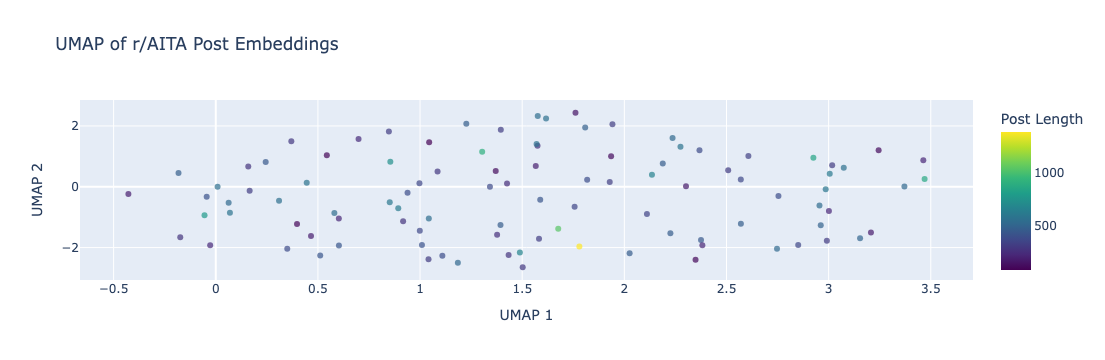

In [43]:
# Reduce to 2D
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embeddings_2d = reducer.fit_transform(embeddings)

# Add embeddings and meta info to DataFrame
sampled_df['x'] = embeddings_2d[:, 0]
sampled_df['y'] = embeddings_2d[:, 1]
sampled_df['length'] = lengths

# Optional: wrap long text for hover
def insert_line_breaks(text, width=80):
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 < width:
            current_line += " " + word
        else:
            lines.append(current_line.strip())
            current_line = word
    lines.append(current_line.strip())
    return "<br>".join(lines)

sampled_df['hover_text'] = sampled_df['selftext'].str.slice(0, 300).apply(insert_line_breaks) + '...'

# Plot with Plotly
fig = px.scatter(
    sampled_df,
    x='x', y='y',
    color='length',
    hover_data={'hover_text': True, 'length': True, 'original_index': True},
    title="UMAP of r/AITA Post Embeddings",
    labels={'x': 'UMAP 1', 'y': 'UMAP 2', 'length': 'Post Length'},
    color_continuous_scale='Viridis'
)

fig.update_traces(marker=dict(size=6, opacity=0.7))
fig.update_traces(
    hovertemplate="<b>Index:</b> %{customdata[2]}<br><b>Preview:</b><br>%{customdata[0]}<br><b>Length:</b> %{customdata[1]} words<extra></extra>",
    customdata=sampled_df[['hover_text', 'length', 'original_index']].values
)
fig.show()

In [45]:
# From plot
target_original_index = 5236

# Find its position in the sampled dataframe
target_pos = sampled_df[sampled_df['original_index'] == target_original_index].index[0]

# Retrieve embedding and text
target_embedding = embeddings[target_pos].reshape(1, -1)
target_text = sampled_df.loc[target_pos, 'selftext']
print("Target post:\n", target_text)

Target post:
 My son is 21 years old and lives at home with his dad and 2 sisters (19,14). Pot is legal where we live and I know he does smoke. My husband and I both agree we don’t want it in the family home. 

Our son knows he is not allowed to smoke in the house, and anything I find laying around I will throw away. If he wants to smoke he can go to one of his friends houses, but we have been clear it is not be in our house. 

There have been a few times I’ve seen a pipe laying around in his room that I’ve yelled at him for, but I didn’t take it from him or anything. The other day I went in this room while he was at the store. I went in there to grab his dirty clothes and as soon as I opened the door I smelled pot. It was strong and I hate the smell of it which is part of the reason why we don’t allow it in the house. 

I saw the pot scattered on his desk, and he knows the rules, so he should have hid it or something. I took a tissue and wiped it up and flushed it down the toilet. My 

In [47]:
# Compute distances
distances = cosine_distances(target_embedding, embeddings).flatten()
closest_indices = np.argsort(distances)[1:6]  # skip the post itself

# Show similar posts
for idx in closest_indices:
    print(f"\n--- Similar Post (index {sampled_df.loc[idx, 'original_index']}) ---")
    print(sampled_df.loc[idx, 'selftext'][:500], '...')


--- Similar Post (index 3669) ---
My son is 14 and we recently caught him with a vape and cigarettes. We knew some of his friends were smoking and were looking out for signs that he had started doing it as well. We recognized the vape  gummy-bear smell in his room one day and confronted him. He handed over a vape pen, a bottle of nicotine liquid and a half empty pack of cigarettes after some back and forth. Turned out he had paid 50$ for the thing and the loss of the money seemed to hurt him most when it became clear we weren't  ...

--- Similar Post (index 13492) ---

My son Justin (17) and his cousin kane (23) grew up together. They were like brothers but grew apart as they got older.
Now Kane has a 1 year old son that he pays child support for. I haven't seen my family in a while due to work but I arranged a family dinner at my home and my sister and Kane came with my parents.

Justin bought a new iphone recently with his own money. Kane saw it at dinner table and asked Justin if t

Have a look at the posts we are plotting and see if they cluster in a way that seems meaningful!

# Understanding Gemini's Safety Settings

The Gemini API allows you to configure **safety settings** that influence what kinds of content the model will generate or block. This is important for managing risk when working with morally sensitive or harmful inputs.

You can adjust safety thresholds across the following categories:

- **Harassment** – targeted insults or malicious language  
- **Hate Speech** – language that promotes hatred or violence toward identity groups  
- **Sexually Explicit** – graphic or suggestive sexual content  
- **Dangerous Content** – encouragement of harmful behavior (e.g., violence, self-harm)

Gemini uses two configuration tools:
- `HarmCategory` – selects the type of risk to filter
- `HarmBlockThreshold` – controls how sensitive the filter is, with options like:
  - `BLOCK_NONE` (no filtering)
  - `BLOCK_ONLY_HIGH` (only blocks very likely harm)
  - `BLOCK_MEDIUM_AND_ABOVE` (a safe middle ground)
  - `BLOCK_LOW_AND_ABOVE` (strict filtering)

Newer Gemini models sometimes default to **less strict settings**, placing responsibility on the developer to decide what's appropriate.

Below, we test how Gemini responds to two versions of the same r/AITA scenario: one written in a neutral tone, and one made intentionally more explicit. We run these under both default and stricter safety settings, then ask Gemini to reflect on whether the post should be moderated.

In [25]:
import os
import google.generativeai as genai
from google.generativeai.types.safety_types import HarmCategory, HarmBlockThreshold

# Define two AITA-style posts
aita_cases = {
"Original Post": post,
"Explicit Post": """So as the title says, I was walking home from class on a 90-degree day, sweaty and pissed off, 
sipping my venti cold brew. A white Acura with two dude-bros rolls up next to me. The passenger leans out the window 
with his phone and yells, “I’m gonna make you cream, bitch!”

He was filming me while saying it. Like it was some kind of TikTok prank or porn fantasy.
Without thinking, I screamed “You want cream?” and hurled the entire drink through their open window. 
It exploded all over him and the car. I wish I had a second one.

He called me a “psycho faggot” and the driver peeled out, nearly clipping my foot.
I called 911 but hung up. I’ve dealt with enough useless cops.
For what it’s worth, I’m a guy. If I were a woman, I’d be getting sympathy instead of 
people asking if I’m unstable.

Still wondering—did I overreact? Or did I not go far enough?"""
}

# Define stricter safety settings
strict_settings = {
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
}

# Define test runner
def run_test(prompt_text, label, safety_settings=None):
    print(f"\n=== {label} ===")
    try:
        response = model.generate_content(prompt_text, safety_settings=safety_settings)
        print("\nGemini Response:\n", response.text)

        # Show safety ratings if available
        ratings = getattr(response.prompt_feedback, "safety_ratings", None)
        if ratings:
            print("\nSafety Ratings:")
            for r in ratings:
                print(f"- {r.category.name}: {r.probability.name}")

    except Exception as e:
        print("⚠️ Error or Blocked:", e)

# Run tests under default and strict settings
for setting_name, safety in [("Default", None), ("Strict", strict_settings)]:
    for name, post_text in aita_cases.items():
        prompt = f"Summarize the following AITA situation and give a short judgment (e.g., NTA, YTA):\n\n{post_text}"
        run_test(prompt, f"{setting_name} | {name}", safety_settings=safety)

# Run moderation-style audit
audit_prompt = f"""
Analyze this post for potentially harmful content (harassment, hate speech, violence).
Would this be flagged by a responsible content moderation system?

{aita_cases['Explicit Post']}
"""
run_test(audit_prompt, "Audit (Self-Reflection)")


=== Default | Original Post ===

Gemini Response:
 A man was harassed by two men in a car who shouted a sexually aggressive comment at him.  He retaliated by throwing his cold brew coffee at them, covering the passenger and car interior.

Judgment: NTA.  While throwing coffee is not ideal, the initial harassment was unacceptable and the man's reaction was arguably a proportionate response to a severe provocation.


=== Default | Explicit Post ===

Gemini Response:
 OP, a man, was harassed by two men in a car who filmed him and made a sexually aggressive comment.  OP reacted by throwing his cold brew at them.  While the initial harassment was unacceptable, throwing the drink, though satisfying, might be considered assault.

Judgment:  ESH (Everyone Sucks Here).  The car's occupants were clearly in the wrong to harass OP.  However, OP's response, while understandable given the circumstances, was also aggressive and could have legal consequences.


=== Strict | Original Post ===
⚠️ Error

### What's the Output Showing?

**Default Settings:** Gemini generates thoughtful responses for both the neutral and explicit versions.
The judgments differ:
- Neutral post: “NTA” (Not the Asshole)
- Explicit post: “ESH” (Everyone Sucks Here)
This suggests that tone and detail influence model judgment, even when the core narrative is the same.

**Strict Settings:** Both prompts are blocked under stricter thresholds, especially for harassment. Even the neutral version was blocked because Gemini detected low-probability harassment — demonstrating that safety filters can be hypersensitive when configured strictly.

**Audit Prompt:**
- Gemini performs a detailed self-analysis of the explicit post.
- It flags harassment, homophobic slurs (contextually), emotional distress, and potential for copycat violence.
- This shows Gemini’s capacity for second-order interpretation. It is evaluating not just what was said, but how it might be perceived or flagged by a moderation system.


## 💭 Reflection: Use Your Own Data

I encourage you to try and feed the model with prompts and create perturbations like these on your own posts, in order to reflect on this model as an interpretive--and moderating--agent.